# Optimizers

Comparison of Keras optimizers done on MNIST dataset. Model was judged based on results from train, validation and test sets.

In [16]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tabulate import tabulate


np.random.seed(2018)
tf.random.set_seed(2018)

In [2]:
NAMES = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']
OPTS = [SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam]

In [8]:
# load and split data
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
xtrain = np.reshape(xtrain, (len(xtrain), -1))
xtest = np.reshape(xtest, (len(xtest), -1))

ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

In [10]:
# scale to [0, 1]
xtrain = np.apply_along_axis(lambda x: x/255, 1, xtrain)
xtest = np.apply_along_axis(lambda x: x/255, 1, xtest)

In [15]:
# create validation set
index = 50000
xval, yval = xtrain[index:], ytrain[index:]
xtrain, ytrain = xtrain[:index], ytrain[:index]
xtrain.shape, xval.shape, xtest.shape

((50000, 784), (10000, 784), (10000, 784))

In [17]:
model = Sequential(
[
    Dense(128, input_shape=xtrain.shape[1:], activation='relu', name='dense_1'),
    Dense(64, activation='relu', name='dense_2'),
    Dropout(0.2),
    Dense(10, activation='softmax', name='dense_3')
], name='Sequential')

model.build(input_shape=xtrain.shape[1:])

In [18]:
model.summary()

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [19]:
# copy original weights to reload them later
weights = model.get_weights().copy()

In [20]:
# params
epochs = 30
batch_size = 64
shuffle = True

# dicts for storing results
loss      = {opt:[] for opt in NAMES}
val_loss  = {opt:[] for opt in NAMES}
acc       = {opt:[] for opt in NAMES}
val_acc   = {opt:[] for opt in NAMES}
test_acc  = {}
test_loss = {}


with tqdm(desc='Training', total=len(NAMES*epochs)) as pbar:
    for optimizer, name in zip(OPTS, NAMES):
        print('Optimizer: ', name)
        
        # prepare model
        model.set_weights(weights)
        model.compile(optimizer=optimizer(), loss='categorical_crossentropy', metrics=['acc'])
        
        # train model
        for epoch in range(epochs):
            his = model.fit(xtrain, ytrain,
                            epochs=1,
                            batch_size=batch_size,
                            validation_data=(xval, yval),
                            shuffle=shuffle,
                            verbose=0)
            
            # update dictionaries
            loss[name].append(his.history['loss'][0])
            val_loss[name].append(his.history['val_loss'][0])
            acc[name].append(his.history['acc'][0])
            val_acc[name].append(his.history['val_acc'][0])   
            pbar.update(1)
            
        # inference
        t_loss, t_acc = model.evaluate(xtest, ytest, verbose=0)
        test_loss[name] = t_loss
        test_acc[name] = t_acc

Optimizer:  SGD
Optimizer:  RMSprop
Optimizer:  Adam
Optimizer:  Adadelta
Optimizer:  Adagrad
Optimizer:  Adamax
Optimizer:  Nadam



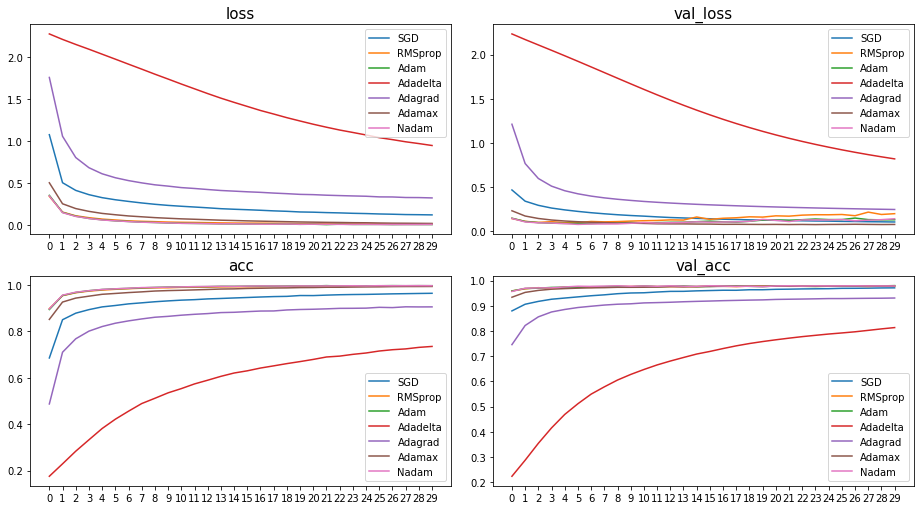

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(13, 7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)


for index, result, title in zip([[0, 0], [0, 1], [1, 0], [1, 1]], 
                                [loss, val_loss, acc, val_acc], 
                                ['loss', 'val_loss', 'acc', 'val_acc']):
    i, j = index
    for name, values in result.items():
        axs[i, j].plot(values, label=name)
        axs[i, j].set_title(title, size=15)
        axs[i, j].set_xticks([e for e in range(epochs)])
        axs[i, j].legend(loc="best", prop={'size': 10})

In [22]:
print(tabulate(sorted(test_acc.items(), key=lambda x: x[1], reverse=True), headers=['Opt', 'Acc']))

Opt          Acc
--------  ------
Adamax    0.9809
Adam      0.9787
RMSprop   0.9783
Nadam     0.9773
SGD       0.9651
Adagrad   0.9291
Adadelta  0.8064


In [23]:
print(tabulate(sorted(test_loss.items(), key=lambda x: x[1], reverse=False), headers=['Opt', 'Loss']))

Opt            Loss
--------  ---------
Adamax    0.0717296
SGD       0.109878
Adam      0.125273
Nadam     0.14209
RMSprop   0.185247
Adagrad   0.258143
Adadelta  0.83074
